In [1]:
!git --version # check the version

git version 2.34.1


In [2]:
!git clone https://github.com/facebook/react.git #clone react
%cd react

Cloning into 'react'...
remote: Enumerating objects: 344900, done.
remote: Counting objects: 100% (17327/17327), done.
remote: Compressing objects: 100% (968/968), done.
remote: Total 344900 (delta 16744), reused 16526 (delta 16318), pack-reused 327573 (from 1)
Receiving objects: 100% (344900/344900), 635.38 MiB | 19.08 MiB/s, done.
Resolving deltas: 100% (244682/244682), done.
/content/react


In [3]:
!pip install lizard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 1.8 MB/s eta 0:00:00


Use Git to extract all commit messages from the repository. Analyze these messages to detect the presence of specific keywords (For example bug fix) related to defect fixes.

Compile a list of all commits that include the identified keywords. Quantify these
results to determine which files are most frequently associated with these commits. Provide the data in a JSON file with the following format:


In [4]:
import os
import subprocess
import json

import os

def normalize_file_paths(file_paths):
    return [os.path.normpath(file_path.lstrip("./")) for file_path in file_paths] #incase different type of key

def save_to_json(data, output_file):
    with open(output_file, "w") as f:
        json.dump(data, f, indent=4)

def save_results_to_json(commit_data, output_file):
    formatted_data = [
        {file_path: data["count"]} for file_path, data in commit_data.items()
    ]

    with open(output_file, "w") as f:
        json.dump(formatted_data, f, indent=4)

KEYWORDS = ["fix", "bug", "error", "issue", "fail", "fixed", "failure"]


#Retrieve the commit history for a specific file in the repository.
def get_file_commit_history(repo_path, file_path):
    result = subprocess.run(
        ["git", "-C", repo_path, "log", "--oneline", file_path],
        capture_output=True,
        text=True
    )
    return result.stdout

def filter_commit_history(commit_history, keywords):
    lines = commit_history.split("\n")
    # Filter lines that contain any of the keywords
    filtered_commits = [line for line in lines if any(keyword in line.lower() for keyword in keywords)]
    return filtered_commits

def find_js_files(repo_path):
    js_files = []
    for root, dirs, files in os.walk(repo_path):
        for file in files:
            if file.endswith(".js"):
                js_files.append(os.path.join(root, file))
    return js_files


REPO_PATH = "./"

# Step 1: Find all .js files in the repository
js_files = find_js_files(REPO_PATH)

# Step 2: Iterate over all .js files and analyze commit history
all_filtered_commits = {}
for file_path in js_files:
    # Get commit history for the file
    commit_history = get_file_commit_history(REPO_PATH, file_path)

    # Filter commit history based on keywords
    filtered_commits = filter_commit_history(commit_history, KEYWORDS)

    # Store filtered commits and their count
    if filtered_commits:
        all_filtered_commits[file_path] = {
            "commits": filtered_commits,
            "count": len(filtered_commits)
        }

OUTPUT_FILE = "defect_frequencies.json"
save_results_to_json(all_filtered_commits, OUTPUT_FILE)



In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!cp defect_frequencies.json /content/drive/MyDrive/

Mounted at /content/drive


Calculate the cyclomatic complexity for each file identified in this JSON file.
Record these complexity scores and visualize the correlation between cyclomatic complexity and the frequency of defects. This analysis will help assess
whether higher complexity correlates with a higher frequency of defects. Consider using tools like McCabe or Lizard for complexity analysis.

Use lizard to calculate cyclomatic complexity for each file in the given list, skipping configuration and test-related files.

In [9]:
def calculate_cyclomatic_complexity(file_list, repo_path, stable_version="main"):
    complexity_data = {}

    # Check out the stable version
    subprocess.run(["git", "-C", repo_path, "checkout", stable_version], check=True)

    for file in file_list:
        try:
            # Use lizard tool to calculate complexity
            result = subprocess.run(
                ["lizard", os.path.join(repo_path, file)],
                capture_output=True,
                text=True
            )
            output = result.stdout.split("\n")
            for line in output:
                if file in line:  # Ensure the line contains the target file
                    parts = line.split()
                    if len(parts) > 1:
                        complexity = float(parts[1])
                        complexity_data[file] = complexity
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    return complexity_data





In [21]:
import matplotlib.pyplot as plt

def normalize_file_paths(file_paths):
    """
    Normalize file paths by removing leading './' and ensuring consistent format.
    """
    return {file.lstrip("./"): file for file in file_paths}

def visualize_correlation(defect_data, complexity_data):
    """
    Visualize the correlation between cyclomatic complexity and defect frequency.
    """
    # Normalize file paths for consistent key matching
    normalized_defect_keys = normalize_file_paths(defect_data.keys())
    normalized_complexity_keys = normalize_file_paths(complexity_data.keys())

    # Find common files based on normalized keys
    common_files = [
        file for file in normalized_defect_keys
        if file in normalized_complexity_keys
    ]

    # Use normalized keys to access original data
    defects = [defect_data[normalized_defect_keys[file]] for file in common_files]
    complexities = [complexity_data[normalized_complexity_keys[file]] for file in common_files]

    # Plot correlation
    plt.figure(figsize=(10, 6))
    #plt.scatter(complexities, defects, alpha=0.7)
    #plt.xlabel("Cyclomatic Complexity")
    #plt.ylabel("Defect Frequency")
    plt.scatter(defects, complexities, alpha=0.7)
    plt.xlabel("Defect Frequency")
    plt.ylabel("Cyclomatic Complexity")
    plt.title("Correlation Between Cyclomatic Complexity and Defect Frequency")
    plt.grid(True)
    plt.show()




In [24]:
#check the format of keys
print(f"Complexity data files: {list(complexity_data.keys())}")
print(f"Defect data files: {list(defect_data.keys())}")

Complexity data files: ['./dangerfile.js', './.eslintrc.js', './ReactVersions.js', './packages/react-devtools-extensions/webpack.config.js', './packages/react-devtools-extensions/webpack.backend.js', './packages/react-devtools-extensions/utils.js', './packages/react-devtools-extensions/build.js', './packages/react-devtools-extensions/deploy.js', './packages/react-devtools-extensions/chrome/test.js', './packages/react-devtools-extensions/chrome/build.js', './packages/react-devtools-extensions/chrome/deploy.js', './packages/react-devtools-extensions/firefox/test.js', './packages/react-devtools-extensions/firefox/build.js', './packages/react-devtools-extensions/firefox/deploy.js', './packages/react-devtools-extensions/popups/shared.js', './packages/react-devtools-extensions/edge/test.js', './packages/react-devtools-extensions/flow-typed/jest.js', './packages/react-devtools-extensions/flow-typed/npm/react-test-renderer_v16.x.x.js', './packages/react-devtools-extensions/src/backend.js', './

In [15]:
if __name__ == "__main__":
    REPO_PATH = "./"
    DEFECT_OUTPUT_FILE = "defect_frequencies.json"
    COMPLEXITY_OUTPUT_FILE = "complexity_analysis.json"
    STABLE_VERSION = "main"

#commit_messages = extract_commit_messages(REPO_PATH)

with open( "defect_frequencies.json", "r") as f:
  defect_data = json.load(f)

if isinstance(defect_data, list):
    defect_data_dict = {}
    for item in defect_data:
        defect_data_dict.update(item)
    defect_data = defect_data_dict

# Calculate cyclomatic complexity in the stable version
file_list = list(defect_data.keys())

complexity_data = calculate_cyclomatic_complexity(file_list, REPO_PATH, stable_version=STABLE_VERSION)

# Save filtered complexity data to JSON
save_to_json(complexity_data, COMPLEXITY_OUTPUT_FILE)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp complexity_analysis.json /content/drive/MyDrive/


Mounted at /content/drive


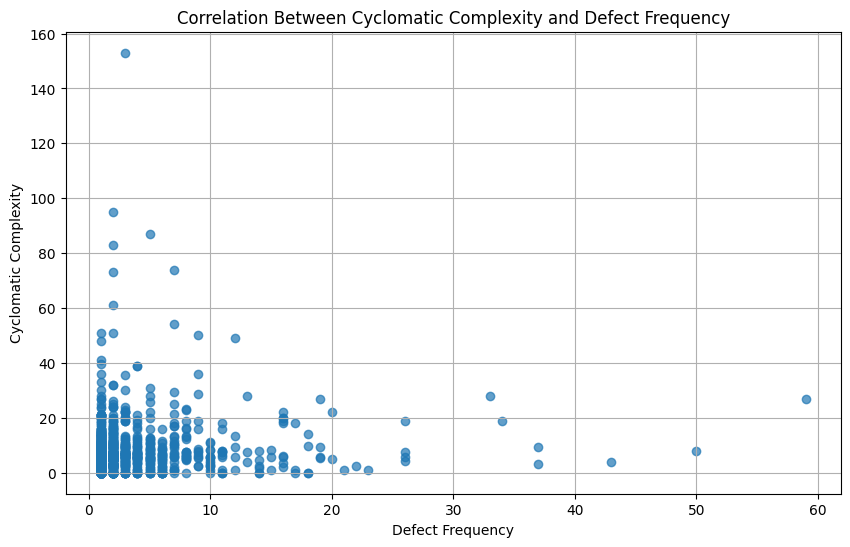

Defect frequency analysis and cyclomatic complexity calculation completed.
Results saved to defect_frequencies.json and complexity_analysis.json


In [22]:
# Visualize correlation
visualize_correlation(defect_data, complexity_data)

print(f"Defect frequency analysis and cyclomatic complexity calculation completed.")
print(f"Results saved to {DEFECT_OUTPUT_FILE} and {COMPLEXITY_OUTPUT_FILE}")

---
---
These are the codes for checking data structure and validating examples.

In [28]:
# glance of the json file
file_path = "/content/drive/MyDrive/defect_frequencies.json"
with open(file_path, "r") as f:
    data = json.load(f)
if isinstance(defect_data, list):
    defect_data_dict = {}
    for item in defect_data:
        defect_data_dict.update(item)
    defect_data = defect_data_dict

from pprint import pprint
for key, value in list(defect_data.items())[:10]:
    print(f"{key}: {value}")

./dangerfile.js: 11
./.eslintrc.js: 14
./ReactVersions.js: 1
./packages/react-devtools-extensions/webpack.config.js: 7
./packages/react-devtools-extensions/webpack.backend.js: 8
./packages/react-devtools-extensions/utils.js: 1
./packages/react-devtools-extensions/build.js: 2
./packages/react-devtools-extensions/deploy.js: 1
./packages/react-devtools-extensions/chrome/test.js: 2
./packages/react-devtools-extensions/chrome/build.js: 1


In [25]:
# glance of the json file
file_path = "/content/drive/MyDrive/complexity_analysis.json"
with open(file_path, "r") as f:
    data = json.load(f)


from pprint import pprint
for key, value in list(data.items())[:10]:
    print(f"{key}: {value}")

./dangerfile.js: 16.0
./.eslintrc.js: 0.0
./ReactVersions.js: 0.0
./packages/react-devtools-extensions/webpack.config.js: 10.6
./packages/react-devtools-extensions/webpack.backend.js: 6.0
./packages/react-devtools-extensions/utils.js: 10.0
./packages/react-devtools-extensions/build.js: 13.4
./packages/react-devtools-extensions/deploy.js: 33.0
./packages/react-devtools-extensions/chrome/test.js: 0.0
./packages/react-devtools-extensions/chrome/build.js: 36.0


In [29]:
normalized_defect_files = normalize_file_paths(defect_data.keys())
normalized_complexity_files = normalize_file_paths(complexity_data.keys())



def convert_defect_data_to_dict(defect_data_list):
    """
    Convert the defect data from a list of dicts to a single dictionary.
    """
    defect_data_dict = {}
    for item in defect_data_list:
        defect_data_dict.update(item)
    return defect_data_dict

def find_extreme_values(defect_data, complexity_data):
    """
    Find the file with the highest complexity and the most defects.
    """

    max_complexity_file = max(complexity_data, key=complexity_data.get)
    max_complexity_value = complexity_data[max_complexity_file]
    max_complexity_defects = defect_data.get(max_complexity_file, 0)

    max_defects_file = max(defect_data, key=defect_data.get)
    max_defects_value = defect_data[max_defects_file]
    max_defects_complexity = complexity_data.get(max_defects_file, 0)

    return {
        "max_complexity_file": max_complexity_file,
        "max_complexity_value": max_complexity_value,
        "max_complexity_defects": max_complexity_defects,
        "max_defects_file": max_defects_file,
        "max_defects_value": max_defects_value,
        "max_defects_complexity": max_defects_complexity,
    }


if isinstance(defect_data, list):
    defect_data = convert_defect_data_to_dict(defect_data)


extreme_values = find_extreme_values(defect_data, complexity_data)


print("File with the highest complexity:")
print(f"  File: {extreme_values['max_complexity_file']}")
print(f"  Complexity: {extreme_values['max_complexity_value']}")
print(f"  Defects: {extreme_values['max_complexity_defects']}")

print("\nFile with the most defects:")
print(f"  File: {extreme_values['max_defects_file']}")
print(f"  Defects: {extreme_values['max_defects_value']}")
print(f"  Complexity: {extreme_values['max_defects_complexity']}")



File with the highest complexity:
  File: ./fixtures/dom/src/components/fixtures/number-inputs/index.js
  Complexity: 153.0
  Defects: 3

File with the most defects:
  File: ./packages/react-reconciler/src/ReactFiberBeginWork.js
  Defects: 59
  Complexity: 27.0


In [30]:
# instance

import subprocess

# Define keywords to filter commit messages
KEYWORDS = ["fix", "bug", "error", "issue", "fail", "fixed", "failure"]

def get_file_commit_history(repo_path, file_path):
    """
    Retrieve the commit history for a specific file in the repository.
    """
    result = subprocess.run(
        ["git", "-C", repo_path, "log", "--oneline", file_path],
        capture_output=True,
        text=True
    )
    return result.stdout

def filter_commit_history(commit_history, keywords):
    """
    Filter the commit history to include only records with specific keywords.
    """
    # Split the commit history into individual lines
    lines = commit_history.split("\n")
    # Filter lines that contain any of the keywords
    filtered_commits = [line for line in lines if any(keyword in line.lower() for keyword in keywords)]
    return filtered_commits

# Example usage
REPO_PATH = "./"
FILE_PATH = "scripts/release/publish-commands/print-follow-up-instructions.js"

# Step 1: Get all commit history for the file
commit_history = get_file_commit_history(REPO_PATH, FILE_PATH)

# Step 2: Filter commit history based on keywords
filtered_commits = filter_commit_history(commit_history, KEYWORDS)

# Step 3: Print filtered commits
print(f"Filtered commit history for {FILE_PATH}:\n")
for commit in filtered_commits:
    print(commit)

# Step 4: Count the number of filtered commits
filtered_count = len(filtered_commits)
print(f"\nTotal number of commits matching keywords: {filtered_count}")


Filtered commit history for scripts/release/publish-commands/print-follow-up-instructions.js:

7e36d8beba Some release script fixes (#20718)
31e6756b8c Remove error code step from publish script (#18350)

Total number of commits matching keywords: 2
